# 💬 Thmanyah Recommender System

This notebook is developed as part of the **Thmanyah training program**. The objective is to analyze user listening behavior and implement a basic **content-based recommendation system** to suggest relevant podcast episodes.

---

## Objectives:
- Load and clean the dataset
- Explore user engagement and episode popularity
- Analyze differences in listening patterns
- Identify each user’s preferred content categories
- Recommend new episodes based on user preferences
- Visualize key findings using charts

---

## Tools Used:
- `Pandas` -> Data Manipulation  
- `Matplotlib` & `Seaborn` -> Visualization  

---

## Dataset:
- `users.csv` — User demographic data  
- `episodes.csv` — Episode metadata
- `listens.json` — Logs of user listening sessions


# 1. Data Preparation

## 1.1 Import Libraries
We import the necessary Python libraries for data analysis and visualization.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

## 1.2 Load the Data
We load the users, episodes, and listening logs using `pandas`.

In [4]:
users_df = pd.read_csv('users.csv')
episodes_df = pd.read_csv('episodes.csv')
listens_df = pd.read_json('listens.json')

# 2. Data Preprocessing

## 2.1 Clean the Listening Logs
Some entries show a `duration_seconds` value of 0, meaning the episode was not actually played. These rows are considered invalid and will be removed.

In [5]:
# Display entries where listening duration is 0 seconds
print(listens_df[listens_df["duration_seconds"] == 0])

    user_id  episode_id  duration_seconds
6        10          25                 0
10       14          13                 0
12       17           6                 0
21        5          15                 0
32       11          29                 0
33        2          19                 0
37        4          28                 0
40       20          22                 0
55       18          10                 0
58        8           5                 0
71       12           7                 0
72       12           2                 0
86       16          16                 0


In [6]:
# Remove rows with zero second listening duration
listens_df = listens_df[listens_df["duration_seconds"] > 0]

# Confirm that no invalid entries remain
print(listens_df[listens_df["duration_seconds"] < 1])

Empty DataFrame
Columns: [user_id, episode_id, duration_seconds]
Index: []


## 2.2 Merge the DataFrames
We combine the `users`, `episodes`, and `listens` data into one single DataFrame for easier analysis.

In [7]:
# Merge user, listen, and episode data into one DataFrame
merge_df = users_df.merge(listens_df, on="user_id")
merge_df = merge_df.merge(episodes_df, on="episode_id")

# Preview the merged dataset
merge_df

,user_id,age,gender,country,episode_id,duration_seconds,title,category
0,1,38,female,Morocco,30,1800,Episode 30,Sports
1,1,38,female,Morocco,8,1500,Episode 8,Sports
2,1,38,female,Morocco,22,900,Episode 22,Society
3,1,38,female,Morocco,1,1800,Episode 1,Religion
4,2,30,female,Jordan,1,300,Episode 1,Religion
...,...,...,...,...,...,...,...,...
82,20,32,female,Egypt,30,1500,Episode 30,Sports
83,20,32,female,Egypt,1,1800,Episode 1,Religion
84,20,32,female,Egypt,7,60,Episode 7,Religion
85,20,32,female,Egypt,29,300,Episode 29,Sports


## 2.3 Remove Missing or Duplicate Rows
We clean the final merged dataset by dropping rows with missing values or duplicates.

In [8]:
# Check and clean missing or duplicate rows
print("Missing Values:", merge_df.isnull().sum())
print("Duplicate Rows:", merge_df.duplicated().sum())

# Remove missing values and duplicates
merge_df.dropna(inplace=True)
merge_df.drop_duplicates(inplace=True)

Missing Values: user_id             0
age                 0
gender              0
country             0
episode_id          0
duration_seconds    0
title               0
category            0
dtype: int64
Duplicate Rows: 0


# 3. Data Analysis (EDA)

## 3.1 Categories with the Most Listens
Which categories are listened to the most?

<Axes: xlabel='category'>

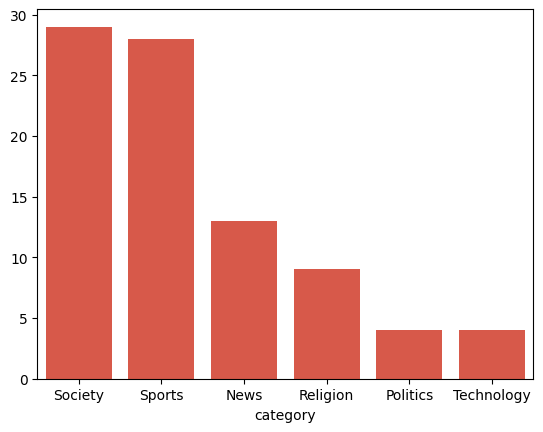

In [9]:
# Plot the most listened-to episode categories
category_count = merge_df["category"].value_counts()
sns.barplot(x=category_count.index,y=category_count.values,color="#ef4632") # Radio Thmanyah Application Logo Color :)

## 3.2 Average Listening Time by Gender
What's the average listening duration for males vs. females?

<Axes: xlabel='gender'>

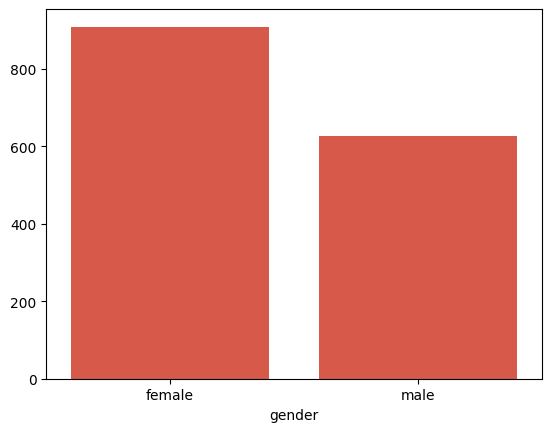

In [10]:
# Plot average listening time by gender
gender_avg_duration = merge_df.groupby("gender")["duration_seconds"]
sns.barplot(x=gender_avg_duration.mean().index, y=gender_avg_duration.mean().values, color="#ef4632")

## 3.3 Average Number of Episodes per User
How many episodes does a typical user listen to?

In [11]:
# Calculate and print average number of episodes listened to per user
episodes_per_user = merge_df.groupby("user_id")["episode_id"].nunique()
print("Average episodes per user:", episodes_per_user.mean())

Average episodes per user: 4.421052631578948


## 3.4 Listening Time by Country
Which countries have the most engaged users?

<Axes: xlabel='country'>

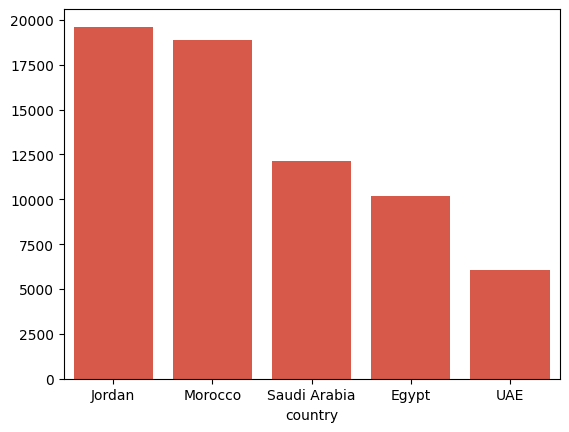

In [12]:
# Plot total listening time by country
country_engagement = merge_df.groupby("country")["duration_seconds"].sum().sort_values(ascending=False)
sns.barplot(x=country_engagement.index, y=country_engagement.values, color="#ef4632")

# 4. Recommender Function

In [13]:
# Content-based recommendation function based on user's favorite category
def recommend_episodes(user_id: int, merge_df, episodes_df):
  # Step 1: Get user's favorite category
  try:
      user_fav_category = merge_df[merge_df["user_id"] == user_id]["category"].value_counts().index[0]
  except IndexError:
      return f"No listening history found for user {user_id}"

  # Step 2: Get all episodes in that category
  category_episodes = episodes_df[episodes_df["category"] == user_fav_category]

  # Step 3: Get episodes already listened to by the user
  user_viewed_episodes = merge_df[(merge_df["user_id"] == 1) & (merge_df["category"] == user_fav_category)]["episode_id"]

  # Step 4: Remove listened episodes from the recommendations
  indexes_to_drop = category_episodes[category_episodes["episode_id"].isin(user_viewed_episodes)].index
  category_episodes.drop(indexes_to_drop, inplace=True)

  # Step 5: Return top 3 recommendations
  return category_episodes.sort_values(by="title", ascending=False).head(3)

In [14]:
# Test the recommender function for a sample user
recommend_episodes(1, merge_df, episodes_df)

,episode_id,title,category
8,9,Episode 9,Sports
28,29,Episode 29,Sports
24,25,Episode 25,Sports


# 5. Results and Recommendations

We successfully built a content-based recommendation system using user listening behavior.

- Each user's favorite episode category was identified
- Based on that category, we recommended 3 new episodes they haven’t listened to yet
- The recommendation avoids already-viewed content to ensure novelty

This approach provides relevant suggestions and is easy to scale or improve.


# 6. Conclusion

In this notebook, we analyzed user behavior and built a simple content-based recommender system. We cleaned the data, identified trends, and used users’ favorite categories to suggest new episodes. This model can be expanded with collaborative filtering or additional content features (e.g., episode descriptions) for future improvements.